In [15]:
import matplotlib.pyplot as plt
import pandas as pd
dataset_path = './'
from logparser import Drain

labels = ['PCA', 'PCA u', 'SVM']
test_precisions = []
test_recalls = []
test_f1s = []
train_precisions = []
train_recalls = []
train_f1s = []

In [7]:
input_dir  = dataset_path + 'loghub/HDFS/'  # The input directory of log file
output_dir = dataset_path + 'loghub/HDFS/'  # The output directory of parsing results
log_file   = 'HDFS_2k.log'  # The input log file name
log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'  # HDFS log format
# Regular expression list for optional preprocessing (default: [])
regex      = [
    r'blk_(|-)[0-9]+' , # block id
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)', # IP
    r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
]
st         = 0.5  # Similarity threshold
depth      = 4  # Depth of all leaf nodes

parser = Drain.LogParser(log_format, indir=input_dir, outdir=output_dir,  depth=depth, st=st, rex=regex)
parser.parse(log_file)

Parsing file: ./loghub/HDFS/HDFS_2k.log
Processed 50.0% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.463880]


In [10]:
from loglizer.models import PCA, SVM
from loglizer import dataloader, preprocessing

PCA Test

In [11]:
struct_log = dataset_path + 'loghub/HDFS/HDFS_2k.log_structured.csv' # The structured log file
label_file = dataset_path + 'loghub/HDFS/anomaly_label.csv' # The anomaly label file

(x_train, y_train), (x_test, y_test) = dataloader.load_HDFS(struct_log, label_file=label_file, window='session',  train_ratio=0.5, split_type='uniform')
feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf', 
                                          normalization='zero-mean')
x_test = feature_extractor.transform(x_test)

model = PCA()
model.fit(x_train)

print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)
train_precisions.append(precision)
train_recalls.append(recall)
train_f1s.append(f1)

print('Test validation:')
precision, recall, f1 = model.evaluate(x_test, y_test)
test_precisions.append(precision)
test_recalls.append(recall)
test_f1s.append(f1)

====== Input data summary ======
Loading ./loghub/HDFS/HDFS_2k.log_structured.csv
34 35
Total: 2200 instances, 69 anomaly, 2131 normal
Train: 1099 instances, 34 anomaly, 1065 normal
Test: 1101 instances, 35 anomaly, 1066 normal

====== Transformed train data summary ======
Train data shape: 1099-by-12

====== Transformed test data summary ======
Test data shape: 1101-by-12

====== Model summary ======
n_components: 9
Project matrix shape: 12-by-12
SPE threshold: 0.7101006121851642

Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.059, F1-measure: 0.111

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.029, F1-measure: 0.056



PCA Unlabeled Test

In [12]:
struct_log = dataset_path + 'loghub/HDFS/HDFS_2k.log_structured.csv' # The structured log file

## 1. Load strutured log file and extract feature vectors
# Save the raw event sequence file by setting save_csv=True
(x_train, _), (_, _), _ = dataloader.load_HDFS(struct_log, window='session', split_type='sequential', save_csv=True)
feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf', normalization='zero-mean')

## 2. Train an unsupervised model
print('Train phase:')
# Initialize PCA, or other unsupervised models, LogClustering, InvariantsMiner
model = PCA() 
# Model hyper-parameters may be sensitive to log data, here we use the default for demo
model.fit(x_train)
# Make predictions and manually check for correctness. Details may need to go into the raw logs
y_train = model.predict(x_train) 

## 3. Use the trained model for online anomaly detection
print('Test phase:')
# Load another new log file. Here we use struct_log for demo only
(x_test, _), (_, _), _ = dataloader.load_HDFS(struct_log, window='session', split_type='sequential')
# Go through the same feature extraction process with training, using transform() instead
x_test = feature_extractor.transform(x_test) 
# Finally make predictions and alter on anomaly cases
y_test = model.predict(x_test)


print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)
train_precisions.append(precision)
train_recalls.append(recall)
train_f1s.append(f1)

print('Test validation:')
precision, recall, f1 = model.evaluate(x_test, y_test)
test_precisions.append(precision)
test_recalls.append(recall)
test_f1s.append(f1)

====== Input data summary ======
Loading ./loghub/HDFS/HDFS_2k.log_structured.csv
Total: 2200 instances, train: 1100 instances, test: 1100 instances
====== Transformed train data summary ======
Train data shape: 1100-by-12

Train phase:
====== Model summary ======
n_components: 9
Project matrix shape: 12-by-12
SPE threshold: 1.014750564165754

Test phase:
====== Input data summary ======
Loading ./loghub/HDFS/HDFS_2k.log_structured.csv
Total: 2200 instances, train: 1100 instances, test: 1100 instances
====== Transformed test data summary ======
Test data shape: 1100-by-12

Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000



SVM Test

In [13]:
struct_log = dataset_path + 'loghub/HDFS/HDFS_2k.log_structured.csv' # The structured log file
label_file = dataset_path + 'loghub/HDFS/anomaly_label.csv' # The anomaly label file

(x_train, y_train), (x_test, y_test) = dataloader.load_HDFS(struct_log, label_file=label_file, window='session',  train_ratio=0.5, split_type='uniform')

feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf')
x_test = feature_extractor.transform(x_test)

model = SVM()
model.fit(x_train, y_train)

print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)
train_precisions.append(precision)
train_recalls.append(recall)
train_f1s.append(f1)

print('Test validation:')
precision, recall, f1 = model.evaluate(x_test, y_test)
test_precisions.append(precision)
test_recalls.append(recall)
test_f1s.append(f1)

====== Input data summary ======
Loading ./loghub/HDFS/HDFS_2k.log_structured.csv
34 35
Total: 2200 instances, 69 anomaly, 2131 normal
Train: 1099 instances, 34 anomaly, 1065 normal
Test: 1101 instances, 35 anomaly, 1066 normal

====== Transformed train data summary ======
Train data shape: 1099-by-12

====== Transformed test data summary ======
Test data shape: 1101-by-12

====== Model summary ======
Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.059, F1-measure: 0.111

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.029, F1-measure: 0.056



Text(0.5, 0, 'Scores')

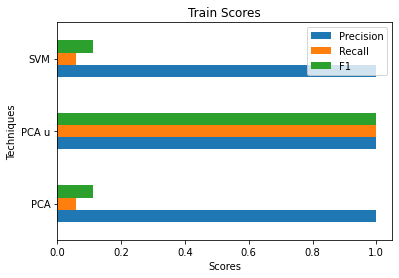

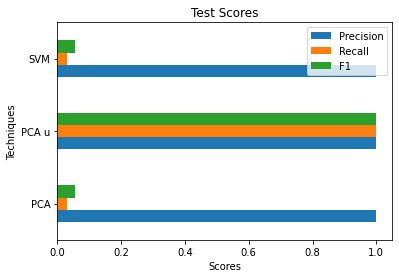

In [14]:
data = {'Precision': train_precisions, 'Recall': train_recalls, 'F1': train_f1s}
df = pd.DataFrame(data,columns=['Precision','Recall', 'F1'], index = labels)
df.plot.barh()

plt.title('Train Scores')
plt.ylabel('Techniques')
plt.xlabel('Scores')

data = {'Precision': test_precisions, 'Recall': test_recalls, 'F1': test_f1s}
df = pd.DataFrame(data,columns=['Precision','Recall', 'F1'], index = labels)
df.plot.barh()

plt.title('Test Scores')
plt.ylabel('Techniques')
plt.xlabel('Scores')